In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def dydx(x,y):
    
    #set derivatives
    
    #our equation is d^2y/dx^2 = -y
    
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we wil set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #here we have to return an array
    return y_derivs


In [31]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + .5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare a temp y array
    y_temps = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temps[:] = yi[:] + .5*k1[:]
    y_derivs = dydx(x_ipoh,y_temps)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temps[:] = yi[:] + .5*k2[:]
    y_derivs = dydx(x_ipoh,y_temps)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temps[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipo,y_temps)
    k2[:] = h*y_derivs[:]
    
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
    
    return yipo

In [38]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step
    while(Delta.max()/tol>1.0):
        
        #estimate our error by taking one step of size h
        #vs. two steps of the same size h/2
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,.5*h_step)
        y_11 = rk4_mv_core(dydx, x_i+.5*h_step, y_1, nv, .5*h_step)

        #compute the error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, take a smaller step
        if (Delta.max()/tol > 1.0):
            
            #our error is too large, decrease the step size
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration
        if(i>imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #iterate
        i += 1
        
    #next time, try to take a larger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, a new step, and the step we actually took
    return y_2, h_new, h_step

In [39]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    #dfdx is the derivative wrt x
    #a is the lower bound
    #b is the upper bound
    #y_a are boudary conditions
    #tol is the tolerance for integrting y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small!
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the initial conditions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set a flag
    flag = 1
    
    #loop until we reach the right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if(xi+h_step>b):
        
            #take a smaller step
            h = b - xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
            #break
            flag = 0
        
        #update values
        xi += h_step
        yi[:] = yi_new[:]
    
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
    
        #prevent too many iterations
        if(i>=imax):
        
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number =",i)
        
        #iterate
        i += 1
    
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i,xi, h_step, b)
        print(s)
    
        #break if new xi is == b
        if(xi==b):
            flag = 0
        
    #return the answer
    return x,y

## Preform the Intergration

In [40]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#preform the intergration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00772103	h = 0.00332280	b=6.28318531
i =   5	x = 0.01109026	h = 0.00336923	b=6.28318531
i =   6	x = 0.01444091	h = 0.00335065	b=6.28318531
i =   7	x = 0.01779907	h = 0.00335816	b=6.28318531
i =   8	x = 0.02115433	h = 0.00335526	b=6.28318531
i =   9	x = 0.02451087	h = 0.00335654	b=6.28318531
i =  10	x = 0.02786704	h = 0.00335617	b=6.28318531
i =  11	x = 0.03122352	h = 0.00335648	b=6.28318531
i =  12	x = 0.03458006	h = 0.00335654	b=6.28318531
i =  13	x = 0.03793677	h = 0.00335671	b=6.28318531
i =  14	x = 0.04129363	h = 0.00335686	b=6.28318531
i =  15	x = 0.04465066	h = 0.00335703	b=6.28318531
i =  16	x = 0.04800788	h = 0.00335722	b=6.28318531
i =  17	x = 0.05136530	h = 0.00335742	b=6.28318531
i =  18	x = 0.05472292	h = 0.00335763	b=6.28318531
i =  19	x = 0.05808077	h = 0.00335785	b=6.28318531
i =  20	x = 0.06143886	h = 0.00

i = 366	x = 1.31044160	h = 0.00356328	b=6.28318531
i = 367	x = 1.31400215	h = 0.00356055	b=6.28318531
i = 368	x = 1.31755999	h = 0.00355784	b=6.28318531
i = 369	x = 1.32111515	h = 0.00355516	b=6.28318531
i = 370	x = 1.32466766	h = 0.00355250	b=6.28318531
i = 371	x = 1.32821753	h = 0.00354987	b=6.28318531
i = 372	x = 1.33176479	h = 0.00354726	b=6.28318531
i = 373	x = 1.33530946	h = 0.00354467	b=6.28318531
i = 374	x = 1.33885156	h = 0.00354211	b=6.28318531
i = 375	x = 1.34239113	h = 0.00353956	b=6.28318531
i = 376	x = 1.34592817	h = 0.00353705	b=6.28318531
i = 377	x = 1.34946272	h = 0.00353455	b=6.28318531
i = 378	x = 1.35299480	h = 0.00353207	b=6.28318531
i = 379	x = 1.35652442	h = 0.00352962	b=6.28318531
i = 380	x = 1.36005161	h = 0.00352719	b=6.28318531
i = 381	x = 1.36357639	h = 0.00352478	b=6.28318531
i = 382	x = 1.36709878	h = 0.00352240	b=6.28318531
i = 383	x = 1.37061881	h = 0.00352003	b=6.28318531
i = 384	x = 1.37413650	h = 0.00351769	b=6.28318531
i = 385	x = 1.37765186	h = 0.00

i = 718	x = 2.51817312	h = 0.00361285	b=6.28318531
i = 719	x = 2.52178917	h = 0.00361604	b=6.28318531
i = 720	x = 2.52540842	h = 0.00361926	b=6.28318531
i = 721	x = 2.52903093	h = 0.00362250	b=6.28318531
i = 722	x = 2.53265670	h = 0.00362578	b=6.28318531
i = 723	x = 2.53628578	h = 0.00362908	b=6.28318531
i = 724	x = 2.53991819	h = 0.00363241	b=6.28318531
i = 725	x = 2.54355396	h = 0.00363577	b=6.28318531
i = 726	x = 2.54719311	h = 0.00363916	b=6.28318531
i = 727	x = 2.55083569	h = 0.00364257	b=6.28318531
i = 728	x = 2.55448171	h = 0.00364602	b=6.28318531
i = 729	x = 2.55813121	h = 0.00364950	b=6.28318531
i = 730	x = 2.56178421	h = 0.00365301	b=6.28318531
i = 731	x = 2.56544076	h = 0.00365655	b=6.28318531
i = 732	x = 2.56910087	h = 0.00366011	b=6.28318531
i = 733	x = 2.57276459	h = 0.00366371	b=6.28318531
i = 734	x = 2.57643193	h = 0.00366735	b=6.28318531
i = 735	x = 2.58010294	h = 0.00367101	b=6.28318531
i = 736	x = 2.58377765	h = 0.00367471	b=6.28318531
i = 737	x = 2.58745608	h = 0.00

i = 1081	x = 3.82110107	h = 0.00336084	b=6.28318531
i = 1082	x = 3.82446212	h = 0.00336105	b=6.28318531
i = 1083	x = 3.82782340	h = 0.00336128	b=6.28318531
i = 1084	x = 3.83118491	h = 0.00336151	b=6.28318531
i = 1085	x = 3.83454667	h = 0.00336176	b=6.28318531
i = 1086	x = 3.83790870	h = 0.00336203	b=6.28318531
i = 1087	x = 3.84127100	h = 0.00336230	b=6.28318531
i = 1088	x = 3.84463360	h = 0.00336259	b=6.28318531
i = 1089	x = 3.84799649	h = 0.00336290	b=6.28318531
i = 1090	x = 3.85135971	h = 0.00336321	b=6.28318531
i = 1091	x = 3.85472325	h = 0.00336354	b=6.28318531
i = 1092	x = 3.85808714	h = 0.00336389	b=6.28318531
i = 1093	x = 3.86145139	h = 0.00336425	b=6.28318531
i = 1094	x = 3.86481600	h = 0.00336462	b=6.28318531
i = 1095	x = 3.86818100	h = 0.00336500	b=6.28318531
i = 1096	x = 3.87154640	h = 0.00336540	b=6.28318531
i = 1097	x = 3.87491220	h = 0.00336581	b=6.28318531
i = 1098	x = 3.87827843	h = 0.00336623	b=6.28318531
i = 1099	x = 3.88164510	h = 0.00336667	b=6.28318531
i = 1100	x =

i = 1383	x = 4.91042789	h = 0.00372519	b=6.28318531
i = 1384	x = 4.91414897	h = 0.00372108	b=6.28318531
i = 1385	x = 4.91786598	h = 0.00371701	b=6.28318531
i = 1386	x = 4.92157895	h = 0.00371297	b=6.28318531
i = 1387	x = 4.92528792	h = 0.00370897	b=6.28318531
i = 1388	x = 4.92899293	h = 0.00370501	b=6.28318531
i = 1389	x = 4.93269401	h = 0.00370108	b=6.28318531
i = 1390	x = 4.93639119	h = 0.00369718	b=6.28318531
i = 1391	x = 4.94008451	h = 0.00369332	b=6.28318531
i = 1392	x = 4.94377400	h = 0.00368949	b=6.28318531
i = 1393	x = 4.94745970	h = 0.00368569	b=6.28318531
i = 1394	x = 4.95114163	h = 0.00368193	b=6.28318531
i = 1395	x = 4.95481983	h = 0.00367820	b=6.28318531
i = 1396	x = 4.95849433	h = 0.00367450	b=6.28318531
i = 1397	x = 4.96216517	h = 0.00367084	b=6.28318531
i = 1398	x = 4.96583237	h = 0.00366720	b=6.28318531
i = 1399	x = 4.96949597	h = 0.00366360	b=6.28318531
i = 1400	x = 4.97315600	h = 0.00366003	b=6.28318531
i = 1401	x = 4.97681249	h = 0.00365649	b=6.28318531
i = 1402	x =

i = 1716	x = 6.05736916	h = 0.00345913	b=6.28318531
i = 1717	x = 6.06083004	h = 0.00346088	b=6.28318531
i = 1718	x = 6.06429269	h = 0.00346265	b=6.28318531
i = 1719	x = 6.06775713	h = 0.00346444	b=6.28318531
i = 1720	x = 6.07122337	h = 0.00346624	b=6.28318531
i = 1721	x = 6.07469144	h = 0.00346807	b=6.28318531
i = 1722	x = 6.07816135	h = 0.00346991	b=6.28318531
i = 1723	x = 6.08163312	h = 0.00347177	b=6.28318531
i = 1724	x = 6.08510676	h = 0.00347365	b=6.28318531
i = 1725	x = 6.08858231	h = 0.00347554	b=6.28318531
i = 1726	x = 6.09205977	h = 0.00347746	b=6.28318531
i = 1727	x = 6.09553916	h = 0.00347940	b=6.28318531
i = 1728	x = 6.09902051	h = 0.00348135	b=6.28318531
i = 1729	x = 6.10250384	h = 0.00348332	b=6.28318531
i = 1730	x = 6.10598915	h = 0.00348532	b=6.28318531
i = 1731	x = 6.10947648	h = 0.00348733	b=6.28318531
i = 1732	x = 6.11296584	h = 0.00348936	b=6.28318531
i = 1733	x = 6.11645724	h = 0.00349141	b=6.28318531
i = 1734	x = 6.11995072	h = 0.00349348	b=6.28318531
i = 1735	x =

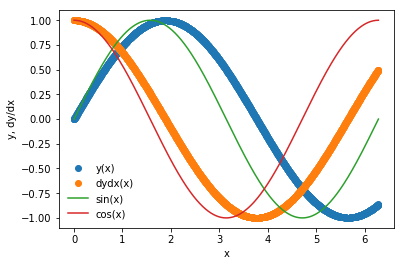

In [41]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)


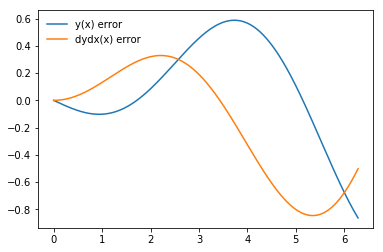

In [42]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label="y(x) error")
plt.plot(x, dydx_error, label="dydx(x) error")
plt.legend(frameon=False)